In [120]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns',50)
sns.set(style = 'darkgrid')
import plotly.express as px
import plotly.graph_objects as go

In [121]:
#stats model api
import statsmodels.api as sm

In [122]:
# reading processed timeseries from the previous analysis phase
df = pd.read_csv('cleaned_results.csv')

In [123]:
#chenge date to datetime field
df.Date = pd.to_datetime(df.Date)

In [124]:
df.head()

,cases,deaths,recovered,country,Date
0,0,0,0,Afghanistan,2020-01-22
1,0,0,0,Afghanistan,2020-01-23
2,0,0,0,Afghanistan,2020-01-24
3,0,0,0,Afghanistan,2020-01-25
4,0,0,0,Afghanistan,2020-01-26


In [125]:
#lets group datewise
df = df.groupby('Date').sum()[['cases' , 'deaths' , 'recovered']]

In [126]:
# get daily data
daily_cases = []
daily_deaths = []
daily_recovers = []
for i in range(df.shape[0]):
    if (i == 0):
#         cases
        cc = 0
        ca = df.iloc[0].cases
        daily_cases.append(abs(ca-cc))
        
#         deaths
        dd = 0
        da = df.iloc[0].deaths
        daily_deaths.append(abs(da-dd))
        
                #         recovers
        rr = 0
        ra = df.iloc[0].recovered
        daily_recovers.append(abs(ra-rr))
        
    elif (i+1) <= df.shape[0]:
#         cases
        cc = df.iloc[i-1].cases
        ca = df.iloc[i].cases
        daily_cases.append(abs(ca-cc)) 
        
        #         deaths
        dd = df.iloc[i-1].deaths
        da = df.iloc[i].deaths
        daily_deaths.append(abs(da-dd))
        
                #         recovers
        rr = df.iloc[i-1].recovered
        ra = df.iloc[i].recovered
        daily_recovers.append(abs(ra-rr))

In [127]:
df['daily_cases'] = daily_cases
df['daily_deaths'] = daily_deaths
df['daily_recovers'] = daily_recovers

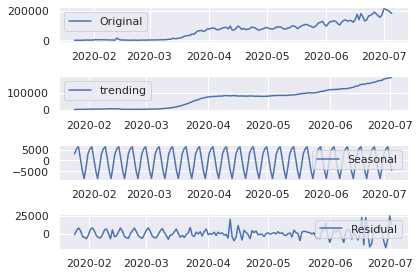

In [128]:
#checking for seasonality , trend etc
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(df['daily_cases'])
trend = decompose.trend
resid = decompose.resid
season = decompose.seasonal

#draw graphs
plt.subplot(411)
plt.plot(df['daily_cases'] , label = "Original")
plt.legend(loc = "best")

plt.subplot(412)
plt.plot(trend , label = "trending")
plt.legend(loc = "best")

plt.subplot(413)
plt.plot(season , label = "Seasonal")
plt.legend(loc = "best")

plt.subplot(414)
plt.plot(resid , label = "Residual")
plt.legend(loc = "best")

plt.tight_layout()

In [129]:
from statsmodels.graphics.tsaplots import plot_pacf , plot_acf
# help(graphics)

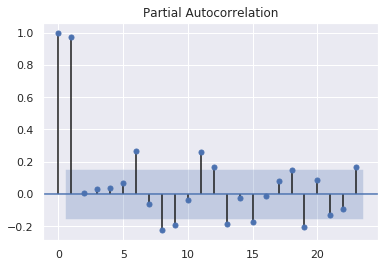

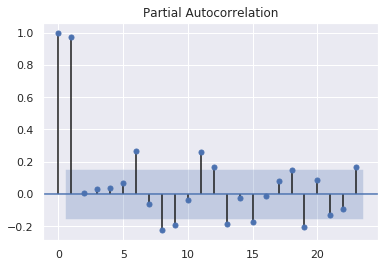

In [130]:
plot_pacf(df['daily_cases'])

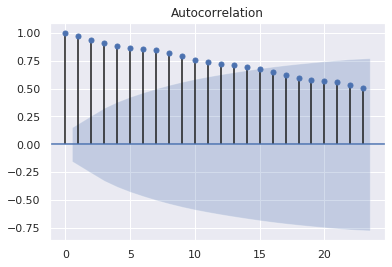

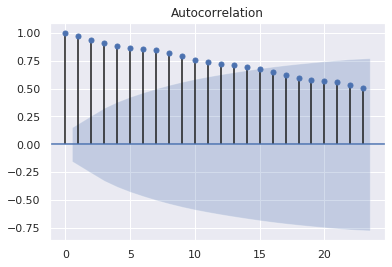

In [131]:
plot_acf(df['daily_cases'])

In [132]:
from statsmodels.tsa.arima_model import ARIMA
# d = 1 , q = 9 , p = 3
len(df['daily_cases'])

166

In [133]:
# df['daily_cases'] = np.log(df['daily_cases'])
df.head(1)

,cases,deaths,recovered,daily_cases,daily_deaths,daily_recovers
Date,,,,,,
2020-01-22,555,17,28,555,17,28


In [134]:
train_cas = np.log(df['daily_cases'][0:120])
test_cas = np.log(df['daily_cases'][120:])
train_death = np.log(df['daily_deaths'][0:120])
test_death = np.log(df['daily_deaths'][120:])
train_rec = np.log(df['daily_recovers'][0:120])
test_rec = np.log(df['daily_recovers'][120:])

In [135]:

model_cas = ARIMA(train_cas.values , order = (9,2,4))

model_death = ARIMA(train_death.values , order = (5,2,4))

model_rec = ARIMA(train_rec.values , order = (6,2,4))

In [136]:
model_fit_cas = model_cas.fit(disp= False)
model_fit_death = model_death.fit(disp= False)
model_fit_rec = model_rec.fit(disp= False)

In [137]:
print(f"Case    {model_fit_cas.aic}")
print(f"Death    {model_fit_death.aic}")
print(f"Recover    {model_fit_rec.aic}")
# model_fit.summary()

Case    175.51842753796214
Death    246.33976179945546
Recover    193.80580047773788


In [138]:
preds_cas = model_fit_cas.forecast(steps = 46)[0]
preds_death = model_fit_death.forecast(steps = 46)[0]
preds_rec = model_fit_rec.forecast(steps = 46)[0]
test1 = pd.DataFrame(test_cas)
test2 = pd.DataFrame(test_death)
test3 = pd.DataFrame(test_rec)
test1['preds'] = preds_cas
test2['preds'] = preds_death
test3['preds'] = preds_rec

In [139]:
test1.head()

,daily_cases,preds
Date,,
2020-05-21,11.576238,11.473606
2020-05-22,11.580266,11.451046
2020-05-23,11.502683,11.456314
2020-05-24,11.464775,11.440157
2020-05-25,11.373353,11.444472


In [140]:
test2.head()

,daily_deaths,preds
Date,,
2020-05-21,8.474703,8.503276
2020-05-22,8.572817,8.248028
2020-05-23,8.291797,8.316071
2020-05-24,7.945201,8.466732
2020-05-25,7.074963,8.247504


In [141]:
test3.head()

,daily_recovers,preds
Date,,
2020-05-21,10.844764,10.678627
2020-05-22,11.595896,10.939410
2020-05-23,10.914561,10.763627
2020-05-24,10.923057,10.999122
2020-05-25,11.062301,10.789146


In [142]:
from sklearn.metrics import mean_squared_error as mse
print(f"Cases  log rmse     {np.sqrt(mse(test1['daily_cases'] , test1['preds']))}")
print(f"Deaths  log rmse     {np.sqrt(mse(test2['daily_deaths'] , test2['preds']))}")
print(f"Recoveries  log rmse     {np.sqrt(mse(test3['daily_recovers'] , test3['preds']))}")

Cases  log rmse     0.9873106201620677
Deaths  log rmse     0.36433723181154704
Recoveries  log rmse     1.4500289891598177


In [143]:
##using xgboosts using cases

In [144]:
df.head()

,cases,deaths,recovered,daily_cases,daily_deaths,daily_recovers
Date,,,,,,
2020-01-22,555,17,28,555,17,28
2020-01-23,654,18,30,99,1,2
2020-01-24,941,26,36,287,8,6
2020-01-25,1434,42,39,493,16,3
2020-01-26,2118,56,52,684,14,13


In [145]:
df1 = df.copy()

In [146]:
# df.index.values

In [147]:
df1.head(1)

,cases,deaths,recovered,daily_cases,daily_deaths,daily_recovers
Date,,,,,,
2020-01-22,555,17,28,555,17,28


In [148]:
#creating the dfs..
df1['date'] = df1.index
df1['hour'] = df1['date'].dt.hour
df1['dayofweek'] = df1['date'].dt.dayofweek
df1['quarter'] = df1['date'].dt.quarter
df1['week'] = df1['date'].dt.week
df1['month'] = df1['date'].dt.month
df1['year'] = df1['date'].dt.year
df1['dayofyear'] = df1['date'].dt.dayofyear
df1['dayofmonth'] = df1['date'].dt.day
df1['weekofyear'] = df1['date'].dt.weekofyear

In [149]:
# cas
test.shape , train.shape

((46,), (120,))

In [150]:
df1.head()

,cases,deaths,recovered,daily_cases,daily_deaths,daily_recovers,date,hour,dayofweek,quarter,week,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,,,,,,,,,
2020-01-22,555,17,28,555,17,28,2020-01-22,0,2,1,4,1,2020,22,22,4
2020-01-23,654,18,30,99,1,2,2020-01-23,0,3,1,4,1,2020,23,23,4
2020-01-24,941,26,36,287,8,6,2020-01-24,0,4,1,4,1,2020,24,24,4
2020-01-25,1434,42,39,493,16,3,2020-01-25,0,5,1,4,1,2020,25,25,4
2020-01-26,2118,56,52,684,14,13,2020-01-26,0,6,1,4,1,2020,26,26,4


In [151]:
# split
cols = ['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear' , 'week']
x_train , y_train = df1[cols][0:120] , df1['daily_cases'][0:120]
x_test , y_test = df1[cols][120:] , df1['daily_cases'][120:]

In [152]:
x_train.shape , x_test.shape , y_train.shape , y_test.shape

((120, 9), (46, 9), (120,), (46,))

In [153]:
from xgboost import XGBRegressor
model = XGBRegressor()
model.fit(x_train , y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [154]:
pred = model.predict(x_test)

In [155]:
np.sqrt(mse(y_test , pred))

53425.061335107726